In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numdifftools as nd
from scipy.interpolate import interp1d

In [2]:
import modules.plots.deconvolution as dec_plots
import modules.experimental_rir as exprir
from modules import randomized_ir, utils, mcmc, adc, cascaded_mcmc

from modules_reloader import reloader
relmod = reloader(dec_plots, exprir, randomized_ir, utils, mcmc, adc, cascaded_mcmc)

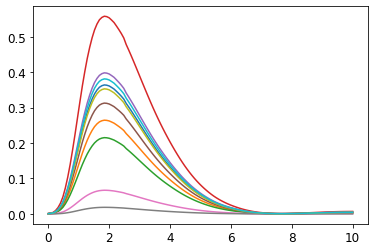

In [3]:
ir_t, ir_shape = exprir.read_ir_shape()
ir_t, ir_shape = exprir.cut_ir_shape(ir_t, ir_shape, excluded_integral_percentile=0.02)

rir = randomized_ir.RandomizedIr(ir_x=ir_t, ir_y=ir_shape, factor=exprir.generate_C_pmt)
L = rir.L

rir.plot_realizations()

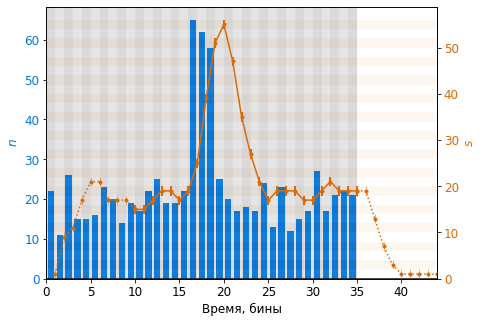

In [4]:
N = 35

n_vec_lambda = 20
n_vec = utils.generate_poissonian_ns(n_vec_lambda, N)

# injecting fake signal in 3 central bins
n_vec[ N//2-1 : N//2+2  ] += 2*n_vec_lambda

adc_step = 2.0

s_vec = adc.adc_accepted_s_vec(rir.convolve_with_n_vec(n_vec), adc_step)

f, a = dec_plots.plot_convolution(n_vec=n_vec, s_vec=s_vec, delta=adc_step)

In [5]:
rireff = randomized_ir.RandomizedIrEffect(rir, N, samplesize=10**6)

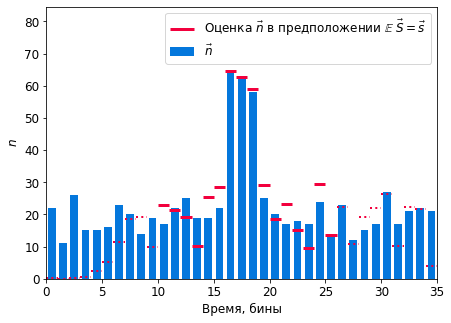

In [6]:
n_vec_estimation = rireff.estimate_n_vec(s_vec, delta=adc_step)
f, a = dec_plots.plot_mean_n_estimation(n_vec, n_vec_estimation, L)

In [7]:
ll_fact = rireff.get_loglikelihood_independent_normdist(s_vec, delta=adc_step, density=False)
ll_fact(n_vec_estimation)  # let the numba do the trick
ll_mvn_density = rireff.get_loglikelihood_mvn(s_vec, delta=adc_step, density=True)
ll_mvn = rireff.get_loglikelihood_mvn(s_vec, delta=adc_step, density=False)

In [8]:
for ll_timed in [utils.timer(lambda *a, **kw: '')(ll) for ll in (ll_fact, ll_mvn_density, ll_mvn)]:
    print(ll_timed(n_vec_estimation))

loglikelihood_normdist() took 1.038300251821056e-05 seconds to complete.
-21.710537039944512
loglikelihood_mvn() took 0.0006312780024018139 seconds to complete.
-25.964137409471896
loglikelihood_mvn() took 0.004403580001962837 seconds to complete.
-14.073021627731265


In [9]:
relmod()

In [59]:
result_preliminary = mcmc.run_mcmc(
    logposterior=ll_fact,
    init_point=n_vec_estimation,
    L=L,
    config=mcmc.SamplingConfig(
        n_walkers=1024,
        n_samples=10000,
        progress_bar=True,
        # autocorr_estimation_each=3000,
        # debug_acceptance_fraction_each=500,
    ) 
)

100%|██████████| 10000/10000 [00:11<00:00, 861.10it/s]


In [60]:
n_walkers_final = 512

init_pts = mcmc.extract_independent_sample(result_preliminary.sampler, desired_sample_size=n_walkers_final)

In [62]:
result = mcmc.run_mcmc(
    logposterior=ll_mvn,
    init_point=init_pts,
    L=L,
    config=mcmc.SamplingConfig(
        n_walkers=n_walkers_final,
        n_samples=1000,
        progress_bar=True,
        starting_points_strategy='given',
    )
)

100%|██████████| 1000/1000 [10:20<00:00,  1.61it/s]


In [63]:
# result_real = cascaded_mcmc.run_cascaded_mcmc(
#     loglikes=[ll_fact, ll_mvn],
#     n_walkers_list=[2048, 1024],
#     n_samples_list=[10000, 500],
#     n_vec_estimation=n_vec_estimation,
#     L=L,
#     generic_sampling_config=mcmc.SamplingConfig(
#         progress_bar=True,
#         autocorr_estimation_each=3000,
#         debug_acceptance_fraction_each=500,
#     )
# )

In [69]:
sample_preliminary = mcmc.extract_independent_sample(result_preliminary.sampler)

Autocorrelation time is estimated at 101.79084468785747 (ranges from 99.70805798995346 to 104.094132498113)
Burn-in = 208 samples
Thinning = 89 samples
(2560, 35)
/home/njvh/Documents/Science/sphere/thesis/modules/plots/deconvolution.py:206: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(


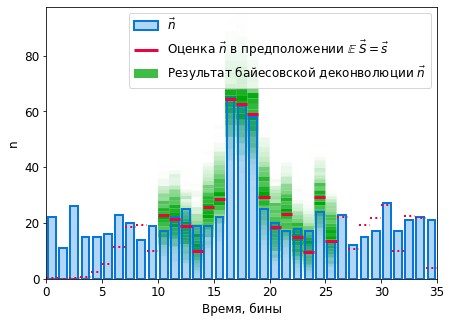

In [70]:
sample = mcmc.extract_independent_sample(result.sampler, debug=True, desired_sample_size=sample_preliminary.shape[0])
# sample = result.sample

print(sample.shape)

f, a = dec_plots.plot_bayesian_mean_estimation(n_vec, sample, L, n_vec_estimation)

In [ ]:
relmod()

(<Figure size 504x360 with 1 Axes>, <AxesSubplot:xlabel='$n_{18}$'>)

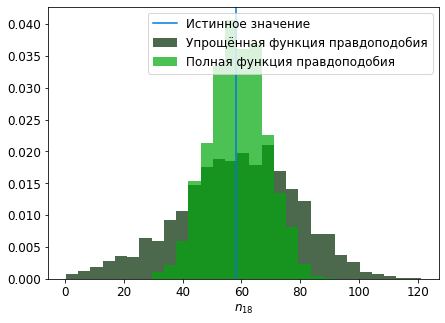

In [71]:
dec_plots.plot_bayesian_mean_estimation_in_bin(
    n_vec,
    [sample_preliminary, sample],
    ['Упрощённая функция правдоподобия', 'Полная функция правдоподобия'],
    18,
)